In [3]:
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, UnstructuredExcelLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain_core.utils.function_calling import convert_to_openai_function
from operator import itemgetter
from pydantic import BaseModel
from typing import Literal
from langchain.chains import ConversationChain
from utils.google_calendar import get_available_slots, crear_evento, borrar_evento

llm bootcamp
check!


In [18]:
import os, sys
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
print(os.environ['LANGCHAIN_PROJECT'])

llm bootcamp


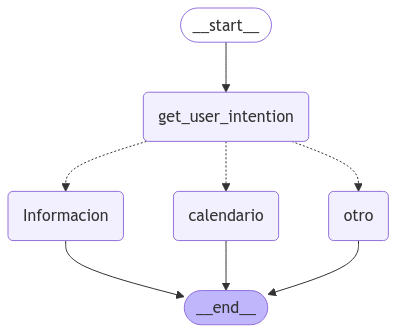

In [28]:
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model="gpt-3.5-turbo")

class ChatBotState(MessagesState):
    Intention : str

class Intention(BaseModel):
    intention : Literal["Informacion", "calendario", "otro"] = Field(description="La intención que se saca del mensaje que da el usuario humano. Se tiene que clasificar entre información o calendario")

INTENTION_MESSAGE = "Eres un asistente en de una farmacia y tu objetivo es ayudar a los clientes a despejar sus dudas. Entre tus funciones está resolver dudas relacionadas con el tema, así como gestionar citas para una reunión en persona con uno de nuestros farmaceúticos. Para poder ayudar mejor, tu tarea va a ser clasificar la intención del usuario entre las \
siguientes opciones : \
   1. Información -> en caso de que necesite saber u obtener consejo sobre la farmacia. Por ejemplo: el usuario quiere saber que dias hacemos guardias \
   2. Calendario: El usuario quiere agendar una cita \
   3. Otro: Esta hablando sobre un tema que no está relacionada con la farmacia."



def get_user_intention(state: ChatBotState):
    llm_with_structured_output = llm.with_structured_output(Intention)
    response = llm_with_structured_output.invoke([AIMessage(INTENTION_MESSAGE)] + state['messages'])
    return {'messages':AIMessage(response.intention),'intention': response.intention}

def router(state: ChatBotState):
    intent = state['intention']
    return intent

def node_info(state:ChatBotState):
    print('----INFO----')
    return {'messages': AIMessage('Aquí')}

def node_calendario(state:ChatBotState):
    print('----CALENDARIO-----')
    return

def node_otro(state:ChatBotState):
    print('----OTRO-----')
    return

builder = StateGraph(ChatBotState)
builder.add_node('get_user_intention', get_user_intention)
builder.add_node('Informacion', node_info)
builder.add_node('calendario', node_calendario)
builder.add_node('otro', node_otro)

builder.add_edge(START, 'get_user_intention')
builder.add_conditional_edges('get_user_intention', router, ['Informacion', 'calendario', 'otro'])
builder.add_edge('Informacion', END)
builder.add_edge('calendario', END)
builder.add_edge('otro', END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config ={ "configurable": {"thread_id": "1"}}
for event in graph.stream({"messages": "Me gustaría saber que horario tiene la farmacia. Abre los domingos?"}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Me gustaría saber que horario tiene la farmacia. Abre los domingos?
================================== Ai Message ==================================

Informacion
----INFO----
================================== Ai Message ==================================

Aquí
